# Customer Life Time Value

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# Uncomment this line if using this notebook locally
#df = pd.read_excel('./data/retail/Online Retail.xlsx', sheet_name='Online Retail')

file_name = "https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/OnlineRetail.xlsx"
df = pd.read_excel(file_name, sheet_name='Online Retail')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [0]:
df.shape

(541909, 8)

In [0]:
# Remove quantities that are less than 0 (possibly returned items)
df = df.loc[df['Quantity'] > 0]

In [0]:
# Remove blank customer IDs
df = df[pd.notnull(df['CustomerID'])]

In [0]:
# View our data range
print('Date Range: %s to %s' % (df['InvoiceDate'].min(), df['InvoiceDate'].max()))

Date Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [0]:
# taking all of the transactions that occurred before December 01, 2011 
df = df.loc[df['InvoiceDate'] < '2011-12-01']

In [0]:
# Create a Sales Revenue Column
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [0]:
# Get a orders summary dataset that shows the total in sales made per customer invoice
orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({'Sales': sum,'InvoiceDate': max})

In [0]:
orders_df.head(10)

Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00
           562032       584.91 2011-08-02 08:48:00
           573511      1294.32 2011-10-31 12:25:00
12348.0    539318       892.80 2010-12-16 19:09:00
           541998       227.44 2011-01-25 10:42:00
           548955       367.00 2011-04-05 10:47:00

In [0]:
# Create some simple functions we'll be using to create our summary dataframe

def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    '''returns the average days between sales'''
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

summary_df = orders_df.reset_index().groupby('CustomerID').agg({
    'Sales': [min, max, sum, groupby_mean, groupby_count],
    'InvoiceDate': [min, max, purchase_duration, avg_frequency]
})

In [0]:
summary_df.head(10)

Sales            ...       InvoiceDate                   
                 min       max  ... purchase_duration purchase_frequency
CustomerID                      ...                                     
12346.0     77183.60  77183.60  ...                 0           0.000000
12347.0       382.52   1294.32  ...               327          54.500000
12348.0       227.44    892.80  ...               282          70.500000
12349.0      1757.55   1757.55  ...                 0           0.000000
12350.0       334.40    334.40  ...                 0           0.000000
12352.0       120.33    840.30  ...               260          32.500000
12353.0        89.00     89.00  ...                 0           0.000000
12354.0      1079.40   1079.40  ...                 0           0.000000
12355.0       459.40    459.40  ...                 0           0.000000
12356.0        58.35   2271.62  ...               302         100.666667

[10 rows x 9 columns]

In [0]:
# Rename our columns by combinng it with the top row
summary_df.columns = ['_'.join(col).lower() for col in summary_df.columns]

In [0]:
summary_df.head()

,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
CustomerID,,,,,,,,,
12346.0,77183.60,77183.60,77183.60,77183.600000,1.0,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.0
12347.0,382.52,1294.32,4085.18,680.863333,6.0,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.5
12348.0,227.44,892.80,1797.24,449.310000,4.0,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.5
12349.0,1757.55,1757.55,1757.55,1757.550000,1.0,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.0
12350.0,334.40,334.40,334.40,334.400000,1.0,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.0


## Visualization 

In [0]:
# Let's look at the first 20 sales counts and the average spend for that sale

# We firstly group by Sales_Counts and then look at the sales_avg 
summary_df.groupby('sales_count').count()['sales_avg'][:20]

sales_count
1.0     1539
2.0      806
3.0      515
4.0      381
5.0      228
6.0      172
7.0      132
8.0       97
9.0       60
10.0      45
11.0      54
12.0      47
13.0      29
14.0      19
15.0      24
16.0      13
17.0      15
18.0      11
19.0      15
20.0      10
Name: sales_avg, dtype: int64

In [0]:
summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]
summary_df

,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
CustomerID,,,,,,,,,
12347.0,382.52,1294.32,4085.18,680.863333,6.0,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.500000
12348.0,227.44,892.80,1797.24,449.310000,4.0,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.500000
12352.0,120.33,840.30,2506.04,313.255000,8.0,2011-02-16 12:33:00,2011-11-03 14:37:00,260,32.500000
12356.0,58.35,2271.62,2811.43,937.143333,3.0,2011-01-18 09:50:00,2011-11-17 08:40:00,302,100.666667
12359.0,547.50,2876.85,6372.58,1593.145000,4.0,2011-01-12 12:43:00,2011-10-13 12:47:00,274,68.500000
...,...,...,...,...,...,...,...,...,...
18270.0,111.95,171.20,283.15,141.575000,2.0,2011-03-18 12:41:00,2011-11-01 13:57:00,228,114.000000
18272.0,340.72,753.66,2710.70,542.140000,5.0,2011-04-07 09:35:00,2011-10-25 11:52:00,201,40.200000
18273.0,51.00,102.00,153.00,76.500000,2.0,2011-03-27 11:22:00,2011-09-05 11:27:00,162,81.000000


Because we're trying to get the time between sales (plotted in the next cell). We need to eliminate single purchases. That's what this line does. 

`summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]`

Purchase durations that are equal to 0 indicate that only purchase was ever made.

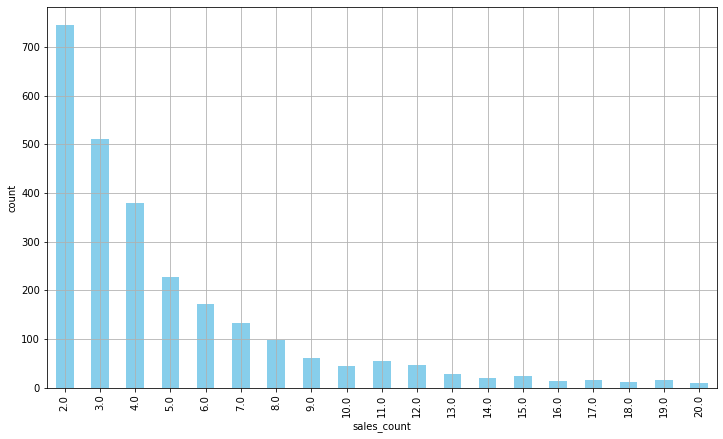

In [0]:
# We filter on invoicedate_purchase_duration greater than 0
summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]

ax = summary_df.groupby('sales_count').count()['sales_avg'][:20].plot(kind='bar', color='skyblue',figsize=(12,7), grid=True)

ax.set_ylabel('count')

plt.show()

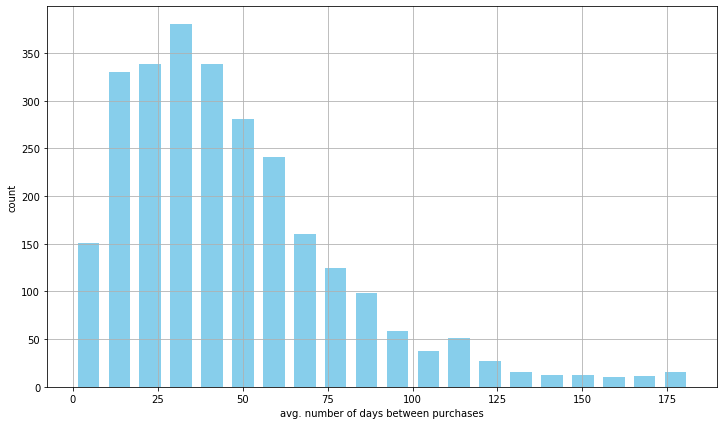

In [0]:
# Now we create a distribution for the average times between sales
ax = summary_df['invoicedate_purchase_frequency'].hist(bins=20, color='skyblue', rwidth=0.7, figsize=(12,7))

ax.set_xlabel('avg. number of days between purchases')
ax.set_ylabel('count')

plt.show()

# Predicting the 3 month Customer Lifetime Value

In [0]:
orders_df.head()

Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00

In [0]:
# Create summary statistics in 3 month intervals for customer Sales

# Use 3M for 3 month
clv_freq = '3M'

# Groupby customer ID now, and group all invoices for 3 month cycles.
# Aggregate on sum, mean and counts
data_df = orders_df.reset_index().groupby(['CustomerID', pd.Grouper(key='InvoiceDate', freq=clv_freq)]).agg({
    'Sales': [sum, groupby_mean, groupby_count],})

data_df.columns = ['_'.join(col).lower() for col in data_df.columns]
data_df = data_df.reset_index()
data_df.head()

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count
0,12346.0,2011-03-31,77183.60,77183.600,1.0
1,12347.0,2010-12-31,711.79,711.790,1.0
2,12347.0,2011-03-31,475.39,475.390,1.0
3,12347.0,2011-06-30,1018.77,509.385,2.0
4,12347.0,2011-09-30,584.91,584.910,1.0


In [0]:
# Adding Recency 'M'

# Get the M
date_month_map = {str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True))}

# Create our M Column
data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[str(x)[:10]])
data_df.head()

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count,M
0,12346.0,2011-03-31,77183.60,77183.600,1.0,M_4
1,12347.0,2010-12-31,711.79,711.790,1.0,M_5
2,12347.0,2011-03-31,475.39,475.390,1.0,M_4
3,12347.0,2011-06-30,1018.77,509.385,2.0,M_3
4,12347.0,2011-09-30,584.91,584.910,1.0,M_2


In [0]:
data_df['M'].unique()

array(['M_4', 'M_5', 'M_3', 'M_2', 'M_1'], dtype=object)

**RFM**

By definition, RFM represents:

- R(ecency): how recently did customer purchase?
- F(rquency): how often do customer purchase?
- M(onetary Value): how much do they spend (each time on average)?

In [0]:
# Create our Features DF
features_df = pd.pivot_table(data_df.loc[data_df['M'] != 'M_1'], values=['sales_sum', 'sales_avg', 'sales_count'], columns='M', index='CustomerID')

features_df.columns = ['_'.join(col) for col in features_df.columns]

features_df.head()

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12346.0,NaN,NaN,77183.600,NaN,NaN,NaN,1.0,NaN,NaN,NaN,77183.60,NaN
12347.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
12348.0,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
12350.0,NaN,NaN,334.400,NaN,NaN,NaN,1.0,NaN,NaN,NaN,334.40,NaN
12352.0,316.25,NaN,312.362,NaN,2.0,NaN,5.0,NaN,632.50,NaN,1561.81,NaN


In [0]:
# Create our Response DF
response_df = data_df.loc[data_df['M'] == 'M_1', ['CustomerID', 'sales_sum']]

response_df.columns = ['CustomerID', 'CLV_'+clv_freq]
response_df.head()

,CustomerID,CLV_3M
5,12347.0,1294.32
10,12349.0,1757.55
14,12352.0,311.73
20,12356.0,58.35
21,12357.0,6207.67


In [0]:
# Create our Sample Set by merging features with response_df
sample_set_df = features_df.merge(
    response_df, 
    left_index=True, 
    right_on='CustomerID',
    how='left'
)

sample_set_df = sample_set_df.fillna(0)
sample_set_df.head()

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
NaN,0.00,0.000,77183.600,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,12346.0,0.00
5.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
NaN,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,12348.0,0.00
NaN,0.00,0.000,334.400,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,12350.0,0.00
14.0,316.25,0.000,312.362,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73


# Using Linear Regression

In [0]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Our Target Variable
target_var = 'CLV_'+clv_freq

# Our Features
all_features = [x for x in sample_set_df.columns if x not in ['CustomerID', target_var]]

# Split data in Train and Test
x_train, x_test, y_train, y_test = train_test_split(sample_set_df[all_features], sample_set_df[target_var], test_size=0.3)

# Fit Model
reg_fit = LinearRegression()
reg_fit.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# Get our y intercept
reg_fit.intercept_

47.175070394817396

In [0]:
# Get our coefficents
reg_fit.coef_

array([   0.51110265,   -0.54905084,    0.24366996,   -1.02299413,
         46.23800934,   42.94976546, -134.52976824,  -57.50173137,
          0.16252426,    0.25933974,    0.2839985 ,    1.16394463])

In [0]:
# Show them here per feature
coef = pd.DataFrame(list(zip(all_features, reg_fit.coef_)))
coef.columns = ['feature', 'coef']

coef

,feature,coef
0,sales_avg_M_2,0.511103
1,sales_avg_M_3,-0.549051
2,sales_avg_M_4,0.243670
3,sales_avg_M_5,-1.022994
4,sales_count_M_2,46.238009
5,sales_count_M_3,42.949765
6,sales_count_M_4,-134.529768
7,sales_count_M_5,-57.501731
8,sales_sum_M_2,0.162524
9,sales_sum_M_3,0.259340


In [0]:
# Run our input data into our model predictors
train_preds = reg_fit.predict(x_train)
test_preds = reg_fit.predict(x_test)

In [0]:
# Assess performance Training Data
from sklearn.metrics import r2_score, median_absolute_error

print(r2_score(y_true=y_train, y_pred=train_preds))
print(median_absolute_error(y_true=y_train, y_pred=train_preds))

0.6530640025746397
203.28508897897652


In [0]:
# Compare R-Squared Performance on Training and Test Datasets
print('In-Sample R-Squared: %0.4f' % r2_score(y_true = y_train, y_pred = train_preds))
print('Out-of-Sample R-Squared: %0.4f' % r2_score(y_true = y_test, y_pred = test_preds))

In-Sample R-Squared: 0.6531
Out-of-Sample R-Squared: 0.6347


In [0]:
# Compare MSE on Training and Test Datasets
print('In-Sample MSE: %0.4f' % median_absolute_error(y_true = y_train, y_pred = train_preds))
print('Out-of-Sample MSE: %0.4f' % median_absolute_error(y_true = y_test, y_pred = test_preds))

In-Sample MSE: 203.2851
Out-of-Sample MSE: 209.4701


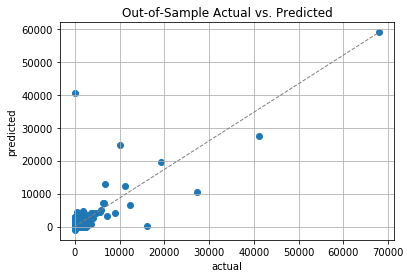

In [0]:
# Plot the predicted vs actual values using our Test Dataset
plt.scatter(y_test, test_preds)
plt.plot([0, max(y_test)], [0, max(test_preds)], color='gray', lw=1, linestyle='--')

plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Out-of-Sample Actual vs. Predicted')
plt.grid()

plt.show()